Prototype de framework pour tester les modèles

In [1]:
from rakuten_common import *

NB_ECHANTILLONS = 20000

In [2]:
class TextEmbed(RakutenBaseModel):
    """
    Modèle avec une première couche Embedding()
    https://keras.io/examples/nlp/pretrained_word_embeddings
    """
    def __init__(self, fit_length=None):
        super().__init__(self.__class__.__name__, fit_length)
        self.maxsentwords = 600 # Nombre max de mots par phrase (tronquées)
        self.embeddim = 200   # Taille des vecteurs d'embedding

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.maxsentwords,), name=self.layer_name("input"))
        x = tf.keras.layers.Embedding(input_dim=self.vocablen, output_dim=self.embeddim,
                                      input_length=self.maxsentwords,
                                      name=self.layer_name("embedding"))(inp)
        x = tf.keras.layers.GlobalAveragePooling1D(name=self.layer_name("GAvePool1D"))(x)
        x = tf.keras.layers.Dense(128, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(x)
        return inp, x

    def __text_to_nparray(self, X):
        self.word2num = {w: i+1 for i, w in enumerate(self.vocab)}
        self.num2word = {self.word2num[w]: w for w in self.word2num}
        X_new = np.zeros((len(X), self.maxsentwords), dtype=int)
        for i, sentence in enumerate(X):
            for j, w in enumerate(sentence[:self.maxsentwords]):
                if w in self.word2num:
                    X_new[i,j] = self.word2num[w]
        return X_new
    
    def preprocess_X_train(self, off_start, off_end, input_file=None):
        self.prt(f"Entrainement de {self.fit_length} échantillons")
        X_train = get_X_text_spacy_lemma_lower(input_file)[off_start:off_end]
 
        maxnb = max([len(sent) for sent in X_train])
        self.prt(f"Nombre de mots max par phrase originel = {maxnb}")
        self.prt(f"Nombre de mots max par phrase utilisé  = {self.maxsentwords}")
        self.vocab = sorted(list({x for sentence in X_train \
                                                for x in sentence[:self.maxsentwords]}))
        self.vocablen = len(self.vocab) + 1 # +1 pour l'id 0 qui correspond au remplissage
        self.prt(f"Taille du vocabulaire (nombre de mots) = {self.vocablen}")

        X_train = self.__text_to_nparray(X_train)
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text_spacy_lemma_lower(input_file)[off_start:off_end]
        X_test = self.__text_to_nparray(X_test)
        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):
        self.fit_length = off_end - off_start
        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
         
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=4, patience_lr=2,
                                         class_weight=[])




++ [13h56mn] TextEmbed: Entrainement de 16000 échantillons
++ [13h56mn] TextEmbed: Nombre de mots max par phrase originel = 2551
++ [13h56mn] TextEmbed: Nombre de mots max par phrase utilisé  = 600
++ [13h56mn] TextEmbed: Taille du vocabulaire (nombre de mots) = 66929
++ [13h56mn] TextEmbed: fit(): Début
Epoch 1/50
425/425 [==============================] - 92s 214ms/step - loss: 2.9194 - accuracy: 0.1796 - val_loss: 2.4670 - val_accuracy: 0.3896
Epoch 2/50
425/425 [==============================] - 89s 210ms/step - loss: 1.7443 - accuracy: 0.5180 - val_loss: 1.4669 - val_accuracy: 0.5758
Epoch 3/50
425/425 [==============================] - 85s 200ms/step - loss: 1.0853 - accuracy: 0.6988 - val_loss: 1.2878 - val_accuracy: 0.6263
Epoch 4/50
425/425 [==============================] - 85s 200ms/step - loss: 0.7067 - accuracy: 0.8051 - val_loss: 0.9948 - val_accuracy: 0.7221
Epoch 5/50
425/425 [==============================] - 85s 200ms/step - loss: 0.4868 - accuracy: 0.8672 - val_loss:

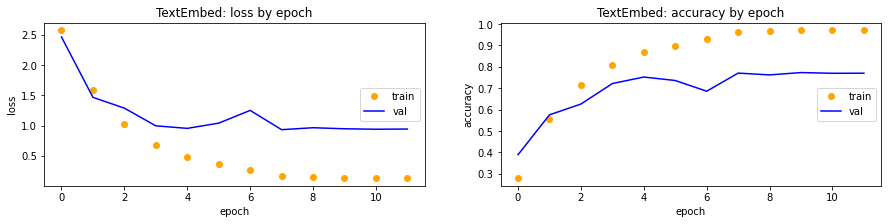

++ [14h13mn] TextEmbed: fit(): Fin

++ [14h13mn] TextEmbed: predict(): Début
125/125 [==============================] - 1s 6ms/step
++ [14h13mn] TextEmbed: predict(): Fin

++ [14h13mn] TextEmbed: w-f1-score = 0.7639

              precision    recall  f1-score   support

          10       0.47      0.72      0.57       155
        1140       0.75      0.70      0.72       128
        1160       0.85      0.90      0.88       168
        1180       0.59      0.31      0.41        32
        1280       0.50      0.55      0.53       214
        1281       0.58      0.49      0.54        85
        1300       0.82      0.78      0.80       228
        1301       0.90      0.86      0.88        44
        1302       0.80      0.67      0.73       132
        1320       0.72      0.72      0.72       136
        1560       0.73      0.78      0.75       242
        1920       0.92      0.86      0.89       222
        1940       0.87      0.74      0.80        35
        2060       0.73   

In [3]:
TextEmbed().evaluate(NB_ECHANTILLONS)

In [3]:
class TextOneHot(RakutenBaseModel):
    """
    Modèle NN exécuté après un préprocessing des données effectué
    avec un pipe sklearn <TfidfVectorizer | SelectFromModel(LinearSVC)>
    """
    def __init__(self, fit_length=None):
        super().__init__(self.__class__.__name__, fit_length)
        self.maxfeatures = 80000 # Nombre de features selectionnées par SVC
                
        self.select = make_pipeline(
            TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  #stop_words=french_stop_words, 
                  # tokenizer=tokenize_spacy, mieux mais long
                  #lowercase=True,
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
 #                 max_features=30000,  moins rentable que celui de SelectFromModel 
                  ),
                  SelectFromModel(LinearSVC(penalty="l2", dual=True, C=0.8,
                                            tol=1e-5, max_iter=4000),
                                  max_features=self.maxfeatures))

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=self.input_shape, name=self.layer_name("input"))
        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(inp)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        y_train_select = get_y()[off_start:off_end]
        X_train = get_X_text(input_file)[off_start:off_end]
        X_train = self.select.fit_transform(X_train, y_train_select).toarray()
        self.input_shape = X_train.shape[1:]
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = self.select.transform(X_test).toarray()
        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()

        return self.compile_and_train_gen(X_train, y_train, X_val, y_val,
                                          optimizer='rmsprop',
                                          epochs=50, patience_stop=7, patience_lr=5,
                                          class_weight=[])
        

++ [14h52mn] TextOneHot: fit(): Début
Epoch 1/50
425/425 [==============================] - 23s 53ms/step - loss: 2.4909 - accuracy: 0.3232 - val_loss: 1.7134 - val_accuracy: 0.6871
Epoch 2/50
425/425 [==============================] - 20s 48ms/step - loss: 1.1673 - accuracy: 0.6826 - val_loss: 0.8513 - val_accuracy: 0.7579
Epoch 3/50
425/425 [==============================] - 20s 46ms/step - loss: 0.7890 - accuracy: 0.7791 - val_loss: 0.7998 - val_accuracy: 0.7654
Epoch 4/50
425/425 [==============================] - 21s 49ms/step - loss: 0.6385 - accuracy: 0.8244 - val_loss: 0.7962 - val_accuracy: 0.7808
Epoch 5/50
425/425 [==============================] - 21s 50ms/step - loss: 0.5110 - accuracy: 0.8617 - val_loss: 0.8404 - val_accuracy: 0.7717
Epoch 6/50
425/425 [==============================] - 21s 49ms/step - loss: 0.4264 - accuracy: 0.8817 - val_loss: 0.8344 - val_accuracy: 0.7829
Epoch 7/50
425/425 [==============================] - 21s 49ms/step - loss: 0.3915 - accuracy: 0.8

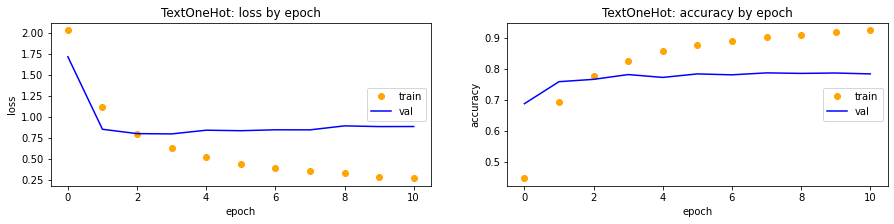

++ [14h56mn] TextOneHot: fit(): Fin

++ [14h56mn] TextOneHot: predict(): Début
125/125 [==============================] - 1s 6ms/step
++ [14h56mn] TextOneHot: predict(): Fin

++ [14h56mn] TextOneHot: w-f1-score = 0.7742

              precision    recall  f1-score   support

          10       0.41      0.66      0.51       155
        1140       0.73      0.77      0.75       128
        1160       0.93      0.91      0.92       168
        1180       0.60      0.09      0.16        32
        1280       0.59      0.63      0.61       214
        1281       0.52      0.52      0.52        85
        1300       0.91      0.86      0.89       228
        1301       1.00      0.70      0.83        44
        1302       0.80      0.74      0.77       132
        1320       0.70      0.69      0.69       136
        1560       0.68      0.84      0.75       242
        1920       0.91      0.91      0.91       222
        1940       0.94      0.91      0.93        35
        2060       0.7

In [8]:
TextOneHot().evaluate(NB_ECHANTILLONS)

In [4]:
class Multilingu(RakutenBaseModel):
    """
    Modèle de plongement (embedding) dans un modèle de texte préentrainé
    (Multilingual-large)
    """
    def __init__(self, fit_length=None):
        super().__init__(self.__class__.__name__, fit_length)
        self.embedding_length = 512 # Défini par le modèle Multilingual/large
        self.std = StandardScaler()

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.embedding_length,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(inp)
        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_train = self.std.fit_transform(X_train)
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_test = self.std.transform(X_test)
        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=8, patience_lr=3, class_weight=[])
        


++ [14h51mn] Multilingu: fit(): Début
Epoch 1/50
425/425 [==============================] - 2s 2ms/step - loss: 2.8223 - accuracy: 0.2441 - val_loss: 1.2640 - val_accuracy: 0.6617
Epoch 2/50
425/425 [==============================] - 1s 2ms/step - loss: 1.6284 - accuracy: 0.5227 - val_loss: 1.0567 - val_accuracy: 0.6950
Epoch 3/50
425/425 [==============================] - 1s 2ms/step - loss: 1.3276 - accuracy: 0.5998 - val_loss: 1.0043 - val_accuracy: 0.7046
Epoch 4/50
425/425 [==============================] - 1s 1ms/step - loss: 1.2376 - accuracy: 0.6255 - val_loss: 0.9338 - val_accuracy: 0.7221
Epoch 5/50
425/425 [==============================] - 1s 2ms/step - loss: 1.1455 - accuracy: 0.6518 - val_loss: 0.9077 - val_accuracy: 0.7308
Epoch 6/50
425/425 [==============================] - 1s 2ms/step - loss: 1.0576 - accuracy: 0.6755 - val_loss: 0.8938 - val_accuracy: 0.7292
Epoch 7/50
425/425 [==============================] - 1s 2ms/step - loss: 1.0318 - accuracy: 0.6794 - val_loss

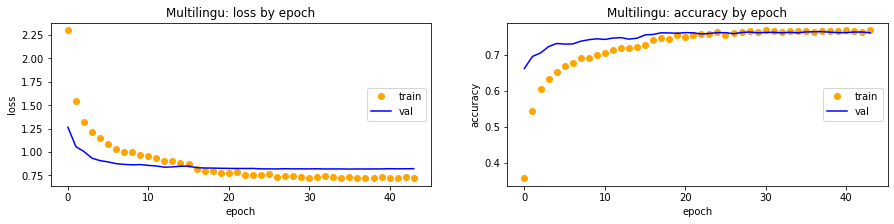

++ [14h52mn] Multilingu: fit(): Fin

++ [14h52mn] Multilingu: predict(): Début
125/125 [==============================] - 0s 688us/step
++ [14h52mn] Multilingu: predict(): Fin

++ [14h52mn] Multilingu: w-f1-score = 0.7552

              precision    recall  f1-score   support

          10       0.55      0.72      0.62       155
        1140       0.68      0.69      0.68       128
        1160       0.85      0.90      0.88       168
        1180       0.47      0.22      0.30        32
        1280       0.61      0.53      0.57       214
        1281       0.68      0.42      0.52        85
        1300       0.78      0.87      0.82       228
        1301       0.89      0.77      0.83        44
        1302       0.68      0.72      0.70       132
        1320       0.70      0.65      0.67       136
        1560       0.68      0.71      0.69       242
        1920       0.86      0.85      0.86       222
        1940       0.81      0.83      0.82        35
        2060       0

In [7]:
Multilingu().evaluate(NB_ECHANTILLONS)

In [5]:
class EffNet(RakutenBaseModel):
    """
    Modèle de transfert learning d'images avec EfficientNet et l'utilisation
    d'un générateur d'images augmentées.
    https://www.dlology.com/blog/transfer-learning-with-efficientnet/
    """

    def __init__(self, fit_length=None):
        super().__init__(self.__class__.__name__, fit_length)
        self.layer_index = 0
        self.input_shape = (240, 240, 3) # Dépend du numéro x (EfficientNetBx)
        self.preprocessing_function = None # Inclus dans le modèle qui attend des données [..255]
        self.basetrainable = 8
        self.epochs_freezed = 10
        self.epochs_unfreezed = 10
        self.batch_size = 32

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une image à partir d'un fichier et la retourner
        au bon format (adapté aux entrées du modèle modèle)
        """
        img = cv2.imread(filepath)
        img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)
        return img

    def get_model_body(self):
        self.basemodel = tf.keras.applications.EfficientNetB1(
                                input_shape = self.input_shape,
                                include_top = False,
                                # drop_connect_rate=0.4,
                                weights = 'imagenet')
        inp = Input(shape=self.input_shape, name="input_" + self.name)
        x = self.basemodel(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True,axis=1, name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(512, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, axis=1, name=self.layer_name("batchnorm"))(x)
        return inp, x

    def __get_train_dataset(self, X_imagepaths, y_train):
        df = pd.DataFrame({"imgpath": X_imagepaths, "class": y_train})
        datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    validation_split = VALIDATION_SPLIT,
                                    preprocessing_function = self.preprocessing_function,
                                    rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1,
                                    brightness_range=[0.9, 1.1],
                                    horizontal_flip = True
                                    )
        traingen = datagenerator.flow_from_dataframe(subset = 'training', dataframe=df,
                                                     x_col="imgpath", y_col="class",
                                                     class_mode="sparse",
                                                     target_size=(self.input_shape[0], self.input_shape[1]),
                                                     batch_size=self.batch_size)
        valgen = datagenerator.flow_from_dataframe(subset='validation',
                                                   dataframe=df, x_col="imgpath", y_col="class",
                                                   class_mode="sparse",
                                                   target_size=(self.input_shape[0], self.input_shape[1]),
                                                   batch_size=self.batch_size)
        return traingen, valgen

    def __get_test_dataset(self, X_imagepaths):
        df = pd.DataFrame({"imgpath": X_imagepaths,
                           "class": [0 for _ in range(len(X_imagepaths))]})
        testgen = tf.keras.preprocessing.image.ImageDataGenerator( 
                        preprocessing_function = self.preprocessing_function).flow_from_dataframe(
                        dataframe=df, x_col="imgpath", y_col="class",
                        class_mode=None, target_size=(self.input_shape[0], self.input_shape[1]),
                        batch_size=1,
                        shuffle = False)
        return testgen
    
    def compile_and_train(self, traingen, valgen, optimizer, patience, epochs):
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min')]
        self.model.compile(optimizer=optimizer,
                           loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen, epochs=epochs,
                                      steps_per_epoch = traingen.n//traingen.batch_size,
                                      validation_data = valgen,
                                      validation_steps = valgen.n//valgen.batch_size,
                                      callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        plot_history(f"{self.name}", history)

    def fit(self, off_start, off_val, off_end, input_file=None):
        self.fit_length = off_end - off_start
        self.prt(f"Entrainement avec {self.fit_length} échantillons")

        self.prt(f"Création des générateurs d'images")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        y_train = get_y()[off_start:off_end]
        traingen, valgen = self.__get_train_dataset(X_imgpaths, y_train)
        self.fit_labels = dict((v,k) for k,v in (traingen.class_indices).items())

        self.model = self.get_model()
        
        self.prt(f"Congélation des layers du modèle de base et entrainement")
        for layer in self.basemodel.layers:
            layer.trainable = False
        history = self.compile_and_train(traingen, valgen,
                                         optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                                         patience=1,
                                         epochs=self.epochs_freezed)
        if self.basetrainable > 0:
            self.prt(f"Décongélation des {self.basetrainable} derniers layers et entrainement")
            for layer in self.basemodel.layers[-self.basetrainable:]:
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
            self.compile_and_train(traingen, valgen,
                                   optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                                   patience=2,
                                   epochs=self.epochs_unfreezed)
        self.prt("Entrainement terminé")
        return history

    def predict(self, off_start, off_end, input_file="X_train_update.csv"):
        """ Prédiction, en utilisant le générateur de données de test """
        length = off_end - off_start
        self.prt(f"Prédiction de {length} échantillons")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        testgen = self.__get_test_dataset(X_imgpaths)
        
        softmaxout = self.model.predict(testgen, verbose = 1)
        assert len(self.fit_labels) == NB_CLASSES
        y_pred = [self.fit_labels[i] for i in np.argmax(softmaxout, axis=1)]
        self.prt("Prédiction terminée")
        return y_pred


In [13]:
EffNet().evaluate(NB_ECHANTILLONS)

++ [14h25mn] EffNet: Entrainement avec 16000 échantillons
++ [14h25mn] EffNet: Création des générateurs d'images
Found 13600 validated image filenames belonging to 27 classes.
Found 2400 validated image filenames belonging to 27 classes.
++ [14h25mn] EffNet: Congélation des layers du modèle de base et entrainement
425/425 [==============================] - 1091s 3s/step - loss: 2.4833 - accuracy: 0.3587 - val_loss: 1.7368 - val_accuracy: 0.5013
++ [14h43mn] EffNet: Entrainement terminé
++ [14h43mn] EffNet: Prédiction de 4000 échantillons
Found 4000 validated image filenames.
4000/4000 [==============================] - 266s 66ms/step
++ [14h47mn] EffNet: Prédiction terminée
++ [14h47mn] EffNet: w-f1-score = 0.492

              precision    recall  f1-score   support

          10       0.56      0.27      0.37       155
        1140       0.64      0.32      0.43       128
        1160       0.74      0.89      0.81       168
        1180       0.19      0.19      0.19        32
     

In [6]:
class CatModel(RakutenCatModel):
    """
    Modèle qui concatene plusieurs modèles de base
    """
    def __init__(self, fit_length=None):
        super().__init__(self.__class__.__name__, fit_length)
        
    def fit(self, off_start, off_val, off_end, input_file=None):
        """
        Entrainement du modèle sur l'intervalle des données spécifié par
        off_start et off_end (offsets dans les fichiers de data).
        """
        self.fit_length = off_end - off_start
        self.prt(f"Entrainement avec {self.fit_length} échantillons")

        self.prt(f'Chargements des modèles référencés "{self.nb}"')
        self.objs = [
#             TextEmbed(self.nb),
             TextOneHot(self.nb),
             Multilingu(self.nb),
             EffNet(self.nb)
        ]

        # Générateurs qui alimenteront fit() avec les données train & val
        traingen, valgen = self.create_train_generators(off_start, off_val, off_end, input_file)
        
        self.prt(f"Création du modèle")
        # Récupèration des inputs et des outputs de chaque modèle de base
        # pour construire le modèle concatenate
        inputlayers, outputlayers = [], []
        for obj in self.objs:
            inp, outp = obj.get_model_body()
            inputlayers.append(inp)
            outputlayers.append(outp)
        
        self.layer_index = 0 # compteur utilisé dans get_model_body()
        concatname = self.layer_name("concatenate")
        x = concatenate(outputlayers, axis=-1, name = concatname)
        x = Dense(64, activation='relu', name=self.layer_name("dense"))(x)
        x = Dropout(0.3, name=self.layer_name("dropout"))(x)
        x = Dense(NB_CLASSES, activation='softmax', name=self.layer_name("dense"))(x)
        self.model = Model(inputlayers, x, name=self.name)

        #print(self.model.summary())

        print(f"  * Layers non entrainables:")
        for layer in self.model.layers[:-3]:
            layer.trainable = False
            print(f"      - {layer.name}")
        print(f"  * Layers entrainables:")
        for layer in self.model.layers:
            if layer.trainable:
                print(f"      - {layer.name}")

        self.model.compile(optimizer= tf.keras.optimizers.Adam(lr=1e-3),
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])

        # Initialisation des poids
        self.copy_submodels_weights()

        self.prt("fit(): Début")    
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min'),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1,
                                                          verbose=1)]
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen,
                                 epochs=12,
                                 validation_data = valgen,
                                 callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        self.prt("fit(): Fin")
        plot_history(f"{self.name}", history)
        return history
                                  
CatModel().evaluate(NB_ECHANTILLONS)

++ [20h05mn] CatModel: Entrainement avec 16000 échantillons
++ [20h05mn] CatModel: Chargements des modèles référencés "20000"
Chargement de l'objet (modele_rakuten_out\TextOneHot_20000_object.pkl)
Chargement du modèle (modele_rakuten_out\TextOneHot_20000_model.hdf5)
Chargement de l'objet (modele_rakuten_out\Multilingu_20000_object.pkl)
Chargement du modèle (modele_rakuten_out\Multilingu_20000_model.hdf5)
Chargement de l'objet (modele_rakuten_out\EffNet_20000_object.pkl)
Chargement du modèle (modele_rakuten_out\EffNet_20000_model.hdf5)
++ [20h05mn] CatModel: Preprocessing des 16000 données d'entrainement


  0%|                                                                                          | 0/425 [00:00<?, ?it/s]

++ [20h05mn] CatModel: Instantiation des générateurs d'entrainement
Nettoyage de modele_rakuten_out\CatDataset_train_13600
Création de 425 fichiers de batch dans modele_rakuten_out\CatDataset_train_13600
* modèle TextOneHot


 19%|███████████████▏                                                                | 81/425 [00:00<00:00, 802.01it/s]

* modèle Multilingu


  0%|                                                                                          | 0/425 [00:00<?, ?it/s]

* modèle EffNet


 11%|████████▊                                                                          | 8/75 [00:00<00:01, 65.72it/s]

Nettoyage de modele_rakuten_out\CatDataset_val_2400
Création de 75 fichiers de batch dans modele_rakuten_out\CatDataset_val_2400
* modèle TextOneHot


  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

* modèle Multilingu
* modèle EffNet


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:12<00:00,  6.02it/s]


++ [20h07mn] CatModel: Création du modèle
  * Layers non entrainables:
      - input_EffNet
      - efficientnetb1
      - input_1_TextOneHot
      - input_1_Multilingu
      - global_average_pooling2d
      - dense_2_TextOneHot
      - batchnorm_2_Multilingu
      - dense_1_EffNet
      - dropout_3_TextOneHot
      - dense_3_Multilingu
      - batchnorm_2_EffNet
      - dense_4_TextOneHot
      - dropout_4_Multilingu
      - dropout_3_EffNet
      - dropout_5_TextOneHot
      - dense_5_Multilingu
      - dense_4_EffNet
      - batchnorm_6_TextOneHot
      - dropout_6_Multilingu
      - batchnorm_5_EffNet
      - concatenate_1_CatModel
  * Layers entrainables:
      - dense_2_CatModel
      - dropout_3_CatModel
      - dense_4_CatModel
  * Init des layers avec les poids des modèles de base:
      - dense_2_TextOneHot
      - dense_4_TextOneHot
      - batchnorm_6_TextOneHot
      - batchnorm_2_Multilingu
      - dense_3_Multilingu
      - dense_5_Multilingu
      - efficientnetb1
     

  2%|█▍                                                                             | 75/4000 [00:00<00:05, 742.76it/s]

++ [20h23mn] CatModel: Instantiation du générateur de test
Création de 4000 fichiers de batch dans modele_rakuten_out\CatDataset_test_4000
* modèle TextOneHot


  9%|██████▌                                                                      | 341/4000 [00:00<00:02, 1691.76it/s]

* modèle Multilingu


  0%|▎                                                                              | 15/4000 [00:00<00:30, 132.10it/s]

* modèle EffNet


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:26<00:00, 151.45it/s]


++ [20h24mn] CatModel: predict(): Début
4000/4000 [==============================] - 251s 62ms/step
++ [20h28mn] CatModel: predict(): Fin

++ [20h28mn] CatModel: w-f1-score = 0.7993

              precision    recall  f1-score   support

          10       0.61      0.82      0.70       155
        1140       0.80      0.77      0.78       128
        1160       0.92      0.95      0.94       168
        1180       0.50      0.12      0.20        32
        1280       0.67      0.52      0.59       214
        1281       0.54      0.52      0.53        85
        1300       0.81      0.93      0.86       228
        1301       1.00      0.75      0.86        44
        1302       0.77      0.80      0.78       132
        1320       0.69      0.74      0.71       136
        1560       0.77      0.75      0.76       242
        1920       0.93      0.86      0.90       222
        1940       0.84      0.91      0.88        35
        2060       0.68      0.78      0.73       248
      